## **Tarun Shah, Adam Tay, Sydney Dinh, & Dan Chizik---SFUSD Project Notebook**

In [2]:
#Import Packages
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import geopandas as gpd
from geopy.distance import geodesic 
from pulp import LpProblem, LpVariable, lpSum, LpMaximize, LpAffineExpression
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'pandas'

In [2]:
#Load In Datasets
application_data = pd.read_excel("AppReq.xlsx")
esaa_data = pd.read_excel("ESAA.xlsx")
seat_data = pd.read_excel("ReqPerSeat.xlsx")

In [3]:
#Clean Up Application Request Data and get Webster Subset
application_data.dropna(subset=['Elementary Attendance Area'], inplace=True)
application_data = application_data[application_data['RequestStatusReason'] != 'Clean up before DSG.']
webster_area_applicants = application_data.loc[application_data['Elementary Attendance Area'].str.contains('Webster')]

#Clean Up ESAA Data
esaa_data.dropna(subset=['Geoid1'], inplace=True)

#Clean Seat Data and get Webster Subset
seat_data.rename(columns={column:seat_data.loc[1, column] for column in seat_data.columns}, inplace=True)
seat_data.drop(index=[0, 1], inplace = True)
webster_seats = seat_data[seat_data['School Name'].str.contains("Webster")]


In [ ]:
#Get Race Proportions Per Block
def get_demographics(esaa_data):
    esaa_data['Percent Asian'] = esaa_data['Total:!!Asian alone']/esaa_data['Total: (Population Race P3 Census 2020.csv)']
    esaa_data['Percent American Indian'] = esaa_data['Total:!!American Indian and Alaska Native alone']/esaa_data['Total: (Population Race P3 Census 2020.csv)']
    esaa_data['Percent Black'] = esaa_data['Total:!!Black or African American alone']/esaa_data['Total: (Population Race P3 Census 2020.csv)']
    esaa_data['Percent Native Hawaiian'] = esaa_data['Total:!!Native Hawaiian and Other Pacific Islander alone']/esaa_data['Total: (Population Race P3 Census 2020.csv)']
    esaa_data['Percent White'] = esaa_data['Total:!!White alone']/esaa_data['Total: (Population Race P3 Census 2020.csv)']
    esaa_data['Percent Two+ Races'] = esaa_data['Total:!!Two or More Races']/esaa_data['Total: (Population Race P3 Census 2020.csv)']
    esaa_data['Percent Other Race'] = esaa_data['Total:!!Some Other Race alone']/esaa_data['Total: (Population Race P3 Census 2020.csv)']

get_demographics(esaa_data)
webster_blocks = esaa_data.loc[1211:1277].drop(columns=['E_AA_NAME'])

In [5]:
#Map Block Attributes onto Applicants
attributes = ['Median HH Income', 'Percent Asian', 'Percent American Indian', 'Percent Black', 'Percent Native Hawaiian', 'Percent White', 'Percent Two+ Races', 'Percent Other Race']
new_attributes = ["Block " + attribute for attribute in attributes]

def get_attributes(block_id):
    match =  esaa_data[esaa_data['Geoid1'] == block_id][attributes]
    if match.empty:
        return [None] * len(attributes)  
    return match.iloc[0].values

mapped_values = webster_area_applicants['Block Group'].apply(get_attributes) 
webster_area_applicants[new_attributes] = pd.DataFrame(mapped_values.tolist(), index=webster_area_applicants.index)

#Get Number of Applicants for Each Block
webster_blocks['Number of Applicants'] = webster_blocks['Geoid1'].apply(lambda x: len(webster_area_applicants[webster_area_applicants['Block Group'] == x]))

/var/folders/0y/9fqdc3696gj8r7lwd7wtfngh0000gn/T/ipykernel_58355/1336849139.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  webster_area_applicants[new_attributes] = pd.DataFrame(mapped_values.tolist(), index=webster_area_applicants.index)
/var/folders/0y/9fqdc3696gj8r7lwd7wtfngh0000gn/T/ipykernel_58355/1336849139.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  webster_area_applicants[new_attributes] = pd.DataFrame(mapped_values.tolist(), index=webster_area_applicants.index)
/var/folders/0y/9fqdc3

In [6]:
#Get Latitude and Longitude for each Block Proup 
#Compute Distance from Webster
shapefile_path = "tl_2024_06_bg/tl_2024_06_bg.shp"  
gdf = gpd.read_file(shapefile_path)

gdf['longitude'] = gdf.geometry.centroid.x
gdf['latitude'] = gdf.geometry.centroid.y

webster_blocks.rename(columns={"Geoid1": "GEOID"}, inplace=True)
webster_blocks['GEOID'] = webster_blocks['GEOID'].apply(lambda id: f"0{str(id).split(".")[0]}")

gdf_subset = gdf[['GEOID', 'longitude', 'latitude']]
webster_blocks = webster_blocks.merge(gdf_subset, on='GEOID', how='left')
webster_blocks['coordinates'] = webster_blocks.apply(lambda x: (x.latitude, x.longitude), axis=1)
webster_coordinates = (37.76055635634658, -122.39584425389323)
webster_blocks['distance'] = webster_blocks.apply(lambda x: geodesic(x.coordinates, webster_coordinates).miles, axis=1)


/var/folders/0y/9fqdc3696gj8r7lwd7wtfngh0000gn/T/ipykernel_58355/1937595558.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['longitude'] = gdf.geometry.centroid.x
/var/folders/0y/9fqdc3696gj8r7lwd7wtfngh0000gn/T/ipykernel_58355/1937595558.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['latitude'] = gdf.geometry.centroid.y


In [7]:
#Use Shannon's Diversity Index to Calculate Single Metrix For Diversity
def shannon_diversity(row):
    proportions = row.filter(like='Percent').astype(float).values
    proportions = proportions[proportions > 0] 
    return -np.sum(proportions * np.log(proportions))

webster_blocks['diversity'] = webster_blocks.apply(shannon_diversity, axis=1)

#Replace Empty Median Income Values with Attendance Area Average
mean_income = webster_blocks.dropna(subset=['Median HH Income'])['Median HH Income'].mean()
webster_blocks['Median HH Income'] = webster_blocks['Median HH Income'].fillna(mean_income)

In [16]:
#Normalize Values for Optimization Algorithm
training_data = webster_blocks[['Median HH Income', 'distance', 'diversity', 'Number of Applicants', 'Total: (Population Race P8 Census 2020.csv)']]

scaler = StandardScaler()
for column in ['Median HH Income', 'distance']:
    training_data[column] = scaler.fit_transform(training_data[[column]])

/var/folders/0y/9fqdc3696gj8r7lwd7wtfngh0000gn/T/ipykernel_58355/1753026587.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data[column] = scaler.fit_transform(training_data[[column]])
/var/folders/0y/9fqdc3696gj8r7lwd7wtfngh0000gn/T/ipykernel_58355/1753026587.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data[column] = scaler.fit_transform(training_data[[column]])


In [22]:
theta = 0.1    #Weight For Socioeconomic Diversity
epsilon = 0.1  #Weight for Ethnic Diversity 
delta = 300    #Threshold for Max Difference in Number of Students Between Attendance Zones

total_students = training_data['Number of Applicants'].sum()

prob = LpProblem("Balanced_Attendance_Areas", LpMaximize)

x = {i: LpVariable(f"x_{i}", cat="Binary") for i in range(len(training_data))}

D_A = lpSum([x[i] * training_data.loc[i, 'diversity'] * training_data.loc[i, 'Total: (Population Race P8 Census 2020.csv)'] for i in range(len(training_data))])
D_B = lpSum([(1 - x[i]) * training_data.loc[i, 'diversity'] * training_data.loc[i, 'Total: (Population Race P8 Census 2020.csv)'] for i in range(len(training_data))])

I_A = lpSum([x[i] * training_data.loc[i, 'Median HH Income'] * training_data.loc[i, 'Number of Applicants'] for i in range(len(training_data))])
I_B = lpSum([(1 - x[i]) * training_data.loc[i, 'Median HH Income'] * training_data.loc[i, 'Number of Applicants'] for i in range(len(training_data))])

z_diversity = LpVariable("z_diversity", lowBound=0)
z_income = LpVariable("z_income", lowBound=0)
prob += z_diversity >= D_A - D_B  
prob += z_diversity >= D_B - D_A
prob += z_income >= I_A - I_B  
prob += z_income >= I_B - I_A

S_A = lpSum([x[i] * training_data.loc[i, 'Number of Applicants'] for i in range(len(training_data))])
S_B = total_students - S_A
z_students = LpVariable("z_students", lowBound=0)
prob += z_students >= S_A - S_B
prob += z_students >= S_B - S_A
prob += z_students <= delta

distance_term = lpSum([-x[i] * training_data.loc[i, 'distance'] for i in range(len(training_data))])
prob += distance_term - (epsilon * z_diversity) - (theta * z_income)
prob.solve()

webster_blocks['assigned_to_webster'] = [x[i].varValue for i in range(len(training_data))]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/tarunshah/Desktop/Venv VS/.venv/lib/python3.12/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/0y/9fqdc3696gj8r7lwd7wtfngh0000gn/T/651a11045a514bf9a79a00169fb2a445-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/0y/9fqdc3696gj8r7lwd7wtfngh0000gn/T/651a11045a514bf9a79a00169fb2a445-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 12 COLUMNS
At line 583 RHS
At line 591 BOUNDS
At line 659 ENDATA
Problem MODEL has 7 rows, 70 columns and 367 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 23.5689 - 0.00 seconds
Cgl0004I processed model has 6 rows, 68 columns (66 integer (66 of which binary)) and 328 elements
Cbc0038I Initial state - 2 integers unsatisfied sum - 0.778065
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 259.958 iterations 4
Cbc0038I 

In [61]:
webster = webster_blocks[webster_blocks['assigned_to_webster'] == 1.0]
mission = webster_blocks[webster_blocks['assigned_to_webster'] == 0.0]

def provide_summary():
    demographic_attributes = ['Total:!!American Indian and Alaska Native alone',
       'Total:!!Asian alone', 'Total:!!Black or African American alone',
       'Total:!!Native Hawaiian and Other Pacific Islander alone',
       'Total:!!White alone', 'Total:!!Two or More Races',
       'Total:!!Some Other Race alone']
    webster_population = webster['Total: (Population Race P3 Census 2020.csv)'].sum()
    mission_population = mission['Total: (Population Race P3 Census 2020.csv)'].sum()
    webster_demographics = {f"Percent {dem.split("!!")[1].split(' alone')[0]}":webster[dem].sum()/webster_population for dem in demographic_attributes}
    mission_demographics = {f"Percent {dem.split("!!")[1].split(' alone')[0]}":mission[dem].sum()/mission_population for dem in demographic_attributes}
    return webster_demographics, mission_demographics

webster_demographics, mission_demographics = provide_summary()

In [62]:
print(webster_demographics)
print(mission_demographics)

{'Percent American Indian and Alaska Native': 0.008122497269748816, 'Percent Asian': 0.3114761558063342, 'Percent Black or African American': 0.07751638150709865, 'Percent Native Hawaiian and Other Pacific Islander': 0.006074808882417182, 'Percent White': 0.4192300691663633, 'Percent Two or More Races': 0.10497815799053513, 'Percent Some Other Race': 0.07260192937750273}
{'Percent American Indian and Alaska Native': 0.008090302367003584, 'Percent Asian': 0.40063091482649843, 'Percent Black or African American': 0.06040902165282517, 'Percent Native Hawaiian and Other Pacific Islander': 0.0020601300457091356, 'Percent White': 0.38631730294641514, 'Percent Two or More Races': 0.08470138844181206, 'Percent Some Other Race': 0.05779093971973648}


In [63]:
print(webster['Median HH Income'].mean())
print(mission['Median HH Income'].mean())

142432.91717325227
144785.69885433713


In [64]:
print(webster['Number of Applicants'].sum())
print(mission['Number of Applicants'].sum())

1848
1911


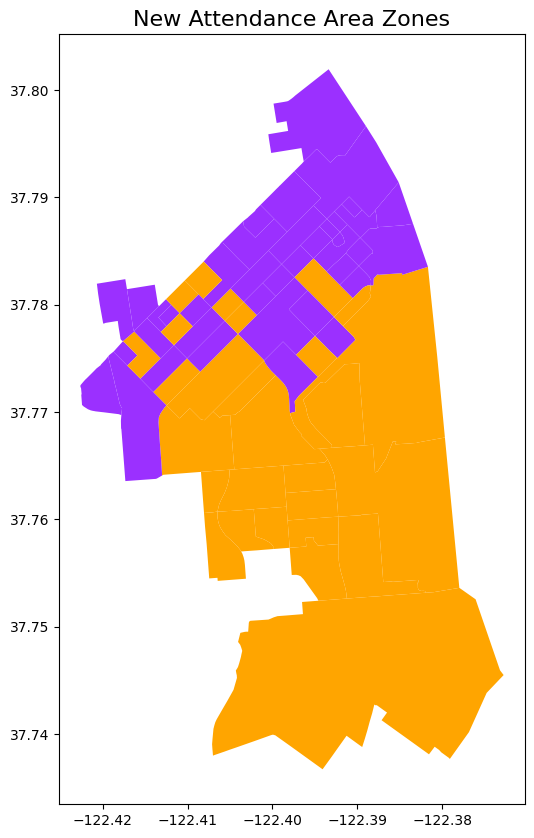

In [50]:
gdf = gpd.read_file("tl_2024_06_bg/tl_2024_06_bg.shp")
gdf = gdf.merge(webster_blocks[['GEOID', 'assigned_to_webster']], on='GEOID', how='left')
gdf['color'] = gdf['assigned_to_webster'].map({1: '#FFA500', 0: '#9B30FF'})
gdf.dropna(subset=['assigned_to_webster'], inplace=True)
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color=gdf['color'], legend=True)
ax.set_title("New Attendance Area Zones", fontsize=16)
plt.savefig('Attendance Area Map')